In [49]:
import numpy as np
import scipy
import scipy.stats
import torch as t
import matplotlib.pyplot as plt

In [50]:
from torch.nn import Sequential, Linear, ReLU, LeakyReLU, Dropout, Sigmoid

In [51]:
%matplotlib inline

In [52]:
if t.cuda.is_available():
    if t.cuda.device_count()>1:
        device = t.device('cuda:1')
    else:
        device = t.device('cuda')   
else:
    device = t.device('cpu')

In [53]:
d1_dist = scipy.stats.norm(loc=3,scale=2)
d2_dist = scipy.stats.norm(loc=0,  scale=0.5)

In [54]:
d1 = d1_dist.rvs(size=50000).astype('float32')
d2 = d2_dist.rvs(25000).astype('float32')

In [55]:
def p_data(x):
    return 2/3*d1_dist.pdf(x)+1/3*d2_dist.pdf(x)

In [56]:
data =np.concatenate((d1,d2)) 
np.random.shuffle(data)
data_t = t.from_numpy(data).view(-1,1)

In [57]:
data_t

tensor([[ 2.7928],
        [ 4.7403],
        [ 0.8903],
        ...,
        [-0.6896],
        [ 4.6869],
        [ 2.2767]])

In [58]:
ys = np.linspace(-5,10,100).astype('float32')

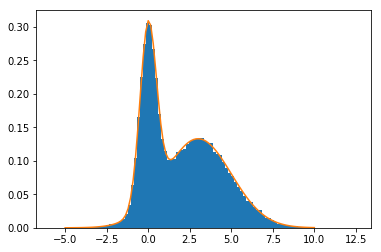

In [59]:
plt.hist(data, bins=100, density=True);
plt.plot(ys, p_data(ys))

In [60]:
noise_dist=scipy.stats.uniform(loc=0, scale=1)

## Inverse cumulant

In [61]:
us = np.linspace(0,1,100).astype('float32')
us_t = t.from_numpy(us).view(-1,1)

In [62]:
def f_generator(u):
    return t.log(u/(1-u))

$$ Y = \log\left(\frac{u}{1-u}\right)$$

$$CDF_{Y}(x)=P(Y<y)$$ 

$$P(\log\left(\frac{u}{1-u}\right)<y)$$ 

$$P\left(\frac{u}{1-u}<e^y\right)$$ 

$$P\left(u<e^y-u e^y\right)$$ 

$$P\left(u(1+ e^y)<e^y\right)$$ 

$$P\left(u<\frac{e^y}{1+ e^y}\right)=\frac{e^y}{1+ e^y}=\frac{1}{1+ e^{-y}} $$ 

$$PDF_Y(x) = \frac{\partial}{\partial y}\frac{1}{1+ e^{-y}}=\frac{e^{-y}}{(1+e^{-y})^2}$$

In [63]:
def p_gen(y):
    e = np.exp(-y)
    return e/((1+e)*(1+e))

In [64]:
p_ys = p_gen(ys).reshape(-1,1)

In [65]:
gen = f_generator(t.FloatTensor(10000,1).uniform_(0,1))

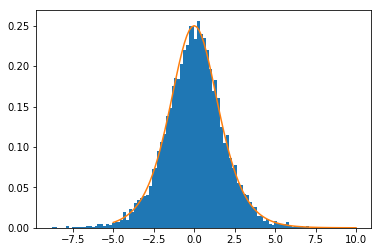

In [66]:
plt.hist(gen.data.numpy().reshape(-1), bins=100, density=True);
plt.plot(ys, p_ys);

### Data

In [67]:
n = 1000
xs = np.linspace(-5,10,n+1)
pdf_data = p_data(xs)
cum_data = np.cumsum(pdf_data)*15/n
cum_data[0]=0.0
cum_data[-1]=1.0

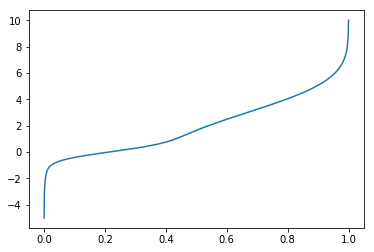

In [68]:
plt.plot(cum_data,xs)

In [69]:
from scipy.interpolate import interp1d

In [70]:
inv_cum_data = interp1d(cum_data, xs,3)

In [71]:
fake_data = inv_cum_data(np.random.uniform(0,1,100000))

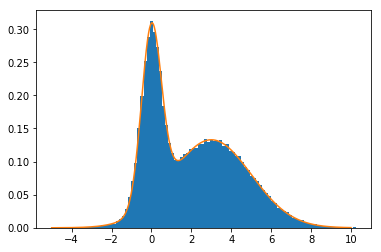

In [72]:
plt.hist(fake_data, bins=100, density=True);
plt.plot(xs, p_data(xs));

## Generative Adversarial Network

In [73]:
def makeNet(n_layers, n_neurons_in_last_layer):
    n = n_layers-1
    n_neurons_in_first_layer = n_neurons_in_last_layer*(2**(n-1))
    modules=[]
    modules.append(Linear(in_features=1, out_features=n_neurons_in_first_layer))
    modules.append(LeakyReLU())
    for i in range(n-1):
        modules.append(Linear(in_features=n_neurons_in_first_layer, out_features=n_neurons_in_first_layer//2))
        modules.append(LeakyReLU())
        n_neurons_in_first_layer//=2
    modules.append(Linear(in_features=n_neurons_in_last_layer, out_features=1))
   
    return Sequential(*modules)

In [74]:
discriminator = Sequential(Linear(1,512), LeakyReLU(0.2, inplace=True),
                           Linear(512,32), LeakyReLU(0.2, inplace=True),
                           Linear(32,1),  Sigmoid()
                                     )

In [75]:
discriminator=discriminator.to(device)
data_t = data_t.to(device)

In [76]:
d_optimizer = t.optim.Adam(discriminator.parameters(), lr=0.0002)

In [77]:
bce = t.nn.BCELoss()

In [78]:
d_out = discriminator(t.from_numpy(ys).view(-1,1).to(device))

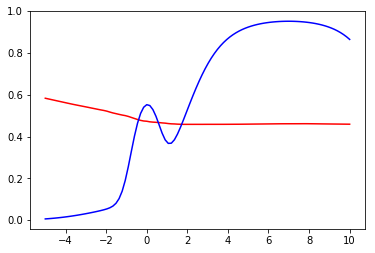

In [79]:
plt.plot(ys,d_out.data.cpu().numpy().reshape(-1),c='r');
plt.plot(ys, p_data(ys)/(p_data(ys)+p_gen(ys)),c='b');

In [80]:
generator = makeNet(5,32)

In [81]:
print(generator)

Sequential(
  (0): Linear(in_features=1, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=64, out_features=32, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=32, out_features=1, bias=True)
)


In [82]:
generator= generator.to(device)

In [83]:
out_t = generator(t.FloatTensor(us_t).to(device));

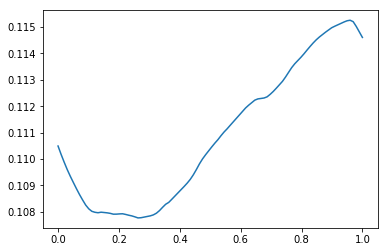

In [84]:
plt.plot(us, out_t.data.cpu().numpy().reshape(-1))

In [85]:
g_optimizer = t.optim.Adam(generator.parameters(), lr=0.0002)

In [86]:
gen = generator(t.empty(10000,1).uniform_(-1,1).to(device))

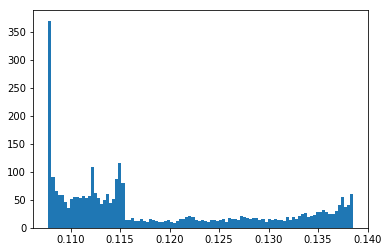

In [87]:
plt.hist(gen.data.cpu().numpy().reshape(-1), bins=100, density=True);
#plt.plot(ys, p_data(ys));

In [88]:
-np.log(0.5)

0.6931471805599453

In [89]:
mini_batch_size = 2048
k_discriminator = 12
k_generator = 1
for epoch in range(1,201):
    for batch in range(len(data)//mini_batch_size):
        for k_d in range(k_discriminator):
            d_optimizer.zero_grad()
            kr = np.random.randint(0,len(data)//mini_batch_size )
          
            d = data_t[kr*mini_batch_size:(kr+1)*mini_batch_size]
            real_labels = t.ones(mini_batch_size, 1, device=device)
            d_real_loss = bce(discriminator(d), 0.9*real_labels)
      
            z = t.empty(mini_batch_size,1, device=device).uniform_(-1,1)
            g_out = generator(z)
            fake_labels = t.zeros(mini_batch_size, 1, device=device)
            d_fake_loss = bce(discriminator(g_out), fake_labels)
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
    
        g_optimizer.zero_grad()
        z = t.empty(mini_batch_size,1, device=device).uniform_(-1,1)
        g_out = generator(z)
        g_loss = bce(discriminator(g_out), real_labels)
        g_loss.backward()
        g_optimizer.step()
        
    if epoch%5 == 0:
        with t.no_grad():
                z = t.empty(len(data_t),1, device=device).uniform_(-1,1)
                real_labels = t.ones(len(data_t),1, device=device)
                fake_labels = t.zeros(len(data_t),1, device=device)
                g_out =  generator(z)
                dg_out = discriminator(g_out)
                d_loss =  bce(discriminator(data_t), real_labels)
                d_loss +=  bce(dg_out, fake_labels)
                
                g_loss = bce(dg_out, real_labels)
                
                print(epoch, d_loss.item(), g_loss.item())     

5 1.3656479120254517 0.8458724617958069
10 1.3718149662017822 0.817359983921051
15 1.3774893283843994 0.8110611438751221
20 1.3755614757537842 0.8097977042198181
25 1.3844223022460938 0.8299487233161926
30 1.3811967372894287 0.7857630252838135
35 1.3845956325531006 0.8037973046302795
40 1.3899428844451904 0.8133092522621155
45 1.3880844116210938 0.8022446632385254
50 1.3901145458221436 0.8152012825012207
55 1.3904149532318115 0.8198248147964478
60 1.3859797716140747 0.7938093543052673
65 1.38637375831604 0.7849090099334717
70 1.3896331787109375 0.7957789301872253
75 1.3941469192504883 0.8145495057106018
80 1.390815019607544 0.8014981150627136
85 1.3874998092651367 0.7758854627609253
90 1.3939034938812256 0.8069838881492615
95 1.3897755146026611 0.8196473717689514
100 1.3921663761138916 0.8029554486274719
105 1.3930014371871948 0.8220686316490173
110 1.3936814069747925 0.8056089282035828
115 1.3448244333267212 0.8500984311103821
120 1.3915491104125977 0.7964109182357788
125 1.3858318328

In [90]:
gen = generator(t.empty(100000,1).uniform_(-1,1).to(device))

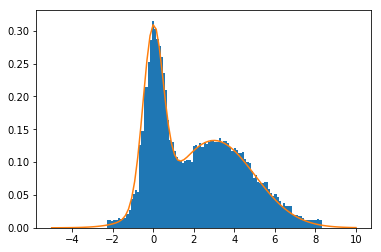

In [91]:
plt.hist(gen.data.cpu().numpy().reshape(-1), bins=100, density=True);
plt.plot(ys, p_data(ys));

In [92]:
d_out = discriminator(t.from_numpy(ys).to(device).view(-1,1))

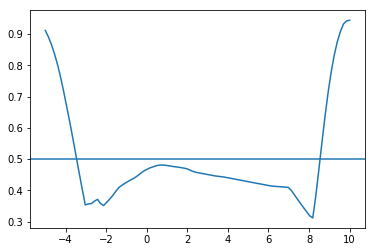

In [93]:
plt.plot(ys,d_out.data.cpu().numpy().reshape(-1));
plt.axhline(0.5);

In [94]:
out_t = generator(t.linspace(-1,1,100).view(-1,1).to(device));

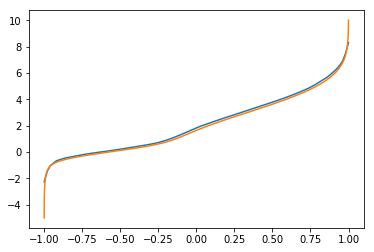

In [95]:
plt.plot(np.linspace(-1,1,100), out_t.data.cpu().numpy().reshape(-1))
plt.plot(2*cum_data-1, xs);